#Mengimport Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import unicodedata
import requests
import nltk
import csv
from io import StringIO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
from collections import Counter
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Memuat Data Hasil Scraping

In [2]:
df = pd.read_csv("review_zoom.csv")
df.head()

,Review,Rating
0,good,5
1,well and super connect the people wherever the...,5
2,❤️,5
3,nice,2
4,it works as I expected,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797304 entries, 0 to 797303
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  797229 non-null  object
 1   Rating  797304 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.2+ MB


#Preprocessing

### Mengecek dan Menghapus Missing Value

In [4]:
df.isna().sum()

,0
Review,75
Rating,0


In [5]:
df = df.dropna()

### Mengecek Duplikasi Data

In [6]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

###Mengecek Persebaran Data Berdasarkan Rating

,Review
Rating,
1,150328
2,27045
3,36572
4,48775
5,208006


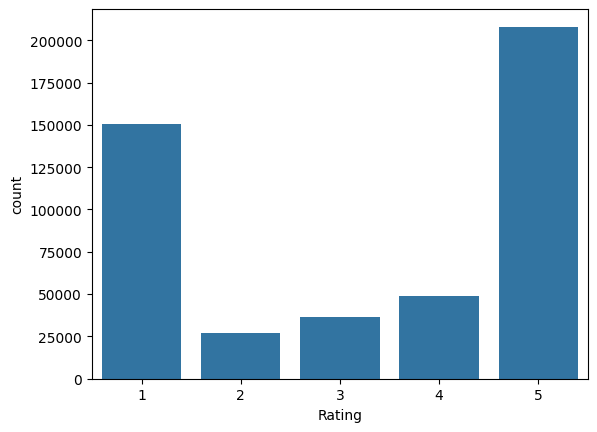

In [7]:
sns.countplot(x='Rating', data = df)
df.groupby(by='Rating').count()

### Memuat Stopword dan Slangword

In [8]:
stop_words = set(stopwords.words('english'))

def get_slang_word_list(url):
    response = requests.get(url)
    response.raise_for_status()
    slang_dict = {}
    for line in response.text.splitlines():
        if ':' in line:
            key, value = line.split(':', 1)
            slang_dict[key.strip()] = value.strip()
    return slang_dict

### Text Cleaning Pipeline

Pipeline ini bertujuan untuk membersihkan dan menyiapkan data review dengan menghilangkan simbol, angka, dan tautan Selain itu, mengoreksi kata slang menjadi bentuk formal menggunakan kamus eksternal; menghapus stopwords yang tidak bermakna penting; serta melakukan lemmatisasi berdasarkan jenis katanya. Dengan egitu, data teks menjadi lebih bersih dan terstruktur.

In [9]:
slang_url = 'https://raw.githubusercontent.com/lhquan244/SlangWord/main/SlangWord_2/SlangWordOriginal.txt'
slangwords = get_slang_word_list(slang_url)
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def processing_text(text):
    if pd.isnull(text):
        return []

    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ').strip().lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)

    pos_tags = pos_tag(tokens)

    cleaned_tokens = [
        lemmatizer.lemmatize(
            slangwords.get(word, word),
            get_wordnet_pos(pos)
        )
        for word, pos in pos_tags
        if word not in stop_words
    ]

    return cleaned_tokens

In [10]:
df_clean = df.copy()
df_clean['Review_Tokenized'] = df_clean['Review'].apply(processing_text)
df_clean['Review_Final'] = df_clean['Review_Tokenized'].apply(lambda x: ' '.join(x))
df_clean = df_clean[df_clean['Review_Final'].str.strip() != '']
df_clean.reset_index(drop=True, inplace=True)

cols = [col for col in df_clean.columns if col != 'Rating'] + ['Rating']
df_clean = df_clean[cols]

df_clean.head()

,Review,Review_Tokenized,Review_Final,Rating
0,good,[good],good,5
1,well and super connect the people wherever the...,"[well, super, connect, people, wherever, easily]",well super connect people wherever easily,5
2,nice,[nice],nice,2
3,it works as I expected,"[work, expect]",work expect,5
4,best app,"[best, app]",best app,5


In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462878 entries, 0 to 462877
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Review            462878 non-null  object
 1   Review_Tokenized  462878 non-null  object
 2   Review_Final      462878 non-null  object
 3   Rating            462878 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 14.1+ MB


Setelah dibersihkan, data yang tersisa yaitu sejumlah 462.878. Hal ini dikarenakan ada review yang hanya menggunakan emoji saja, sehingga terhapus dan menjadi nilai yang kosong. Maka, datanya saya hapus agar tidak mengganggu pelatihan.

#Pelabelan Berbasis Kamus Sentimen

###Memuat Lexicon atau Kamus Positif dan Negatif dari External

In [12]:
def load_lexicon(url, score):
    lexicon = dict()
    response = requests.get(url)
    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter='\n')
        for row in reader:
            lexicon[row[0].strip().lower()] = score
    else:
        print(f"Failed to fetch lexicon from {url}")
    return lexicon

positive_url = 'https://raw.githubusercontent.com/zengyan-97/Sentiment-Lexicon/master/positive.txt'
negative_url = 'https://raw.githubusercontent.com/zengyan-97/Sentiment-Lexicon/master/negative.txt'

lexicon_positive = load_lexicon(positive_url, 3)
lexicon_negative = load_lexicon(negative_url, -3)

### Analisis Sentimen Berbasis Lexicon

In [13]:
def sentiment_analysis_lexicon(text):
    score = 0
    for word in text:
        word = word.lower()
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    # Threshold
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

### Analisis Sentimen Berbasis Rating

In [14]:
def sentiment_analysis_rating(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

### Analisis Sentimen Berbasis Lexicon dan Rating (kombinasi)

In [15]:
def combined_sentiment_analysis(text, rating):
    score_lex, lexicon_polarity = sentiment_analysis_lexicon(text)

    if rating >= 4:
        rating_score = rating - 3
    elif rating == 3:
        rating_score = 0
    else:
        rating_score = rating - 4


    final_score = score_lex + rating_score

    if final_score > 1:
        final_polarity = 'positive'
    elif final_score < -1:
        final_polarity = 'negative'
    else:
        final_polarity = 'neutral'

    return final_score, final_polarity

### Implementasi Fungsi Analisis

In [16]:
results_lexicon = df_clean['Review_Tokenized'].apply(sentiment_analysis_lexicon)
df_clean['sentimen_score_lexicon'], df_clean['sentimen_lexicon'] = zip(*results_lexicon)

df_clean['sentimen_rating'] = df_clean['Rating'].apply(sentiment_analysis_rating)

results_combined = df_clean.apply(
    lambda row: combined_sentiment_analysis(row['Review_Tokenized'], row['Rating']), axis=1
)
df_clean['sentimen_score_combined'], df_clean['sentimen_combined'] = zip(*results_combined)

###Hasil Implementasi

In [17]:
df_clean.head()

,Review,Review_Tokenized,Review_Final,Rating,sentimen_score_lexicon,sentimen_lexicon,sentimen_rating,sentimen_score_combined,sentimen_combined
0,good,[good],good,5,3,positive,positive,5,positive
1,well and super connect the people wherever the...,"[well, super, connect, people, wherever, easily]",well super connect people wherever easily,5,9,positive,positive,11,positive
2,nice,[nice],nice,2,3,positive,negative,1,neutral
3,it works as I expected,"[work, expect]",work expect,5,3,positive,positive,5,positive
4,best app,"[best, app]",best app,5,3,positive,positive,5,positive


###Distribusi Sentimen Berdasarkan Metode Analisis

In [18]:
print("\nSentiment based on Lexicon:")
print(df_clean['sentimen_lexicon'].value_counts())

print("\nSentiment based on Rating:")
print(df_clean['sentimen_rating'].value_counts())

print("Combined Sentiment (Lexicon + Rating):")
print(df_clean['sentimen_combined'].value_counts())


Sentiment based on Lexicon:
sentimen_lexicon
positive    242821
neutral     140002
negative     80055
Name: count, dtype: int64

Sentiment based on Rating:
sentimen_rating
positive    251924
negative    174846
neutral      36108
Name: count, dtype: int64
Combined Sentiment (Lexicon + Rating):
sentimen_combined
positive    263632
negative    136966
neutral      62280
Name: count, dtype: int64


### Melakukan Explorasi Label

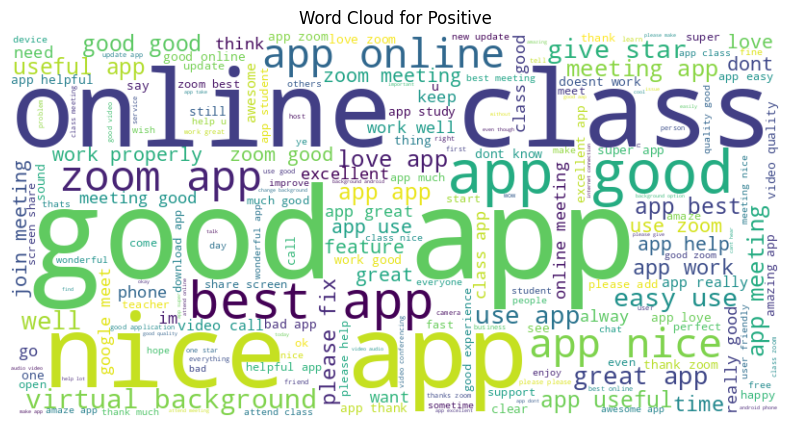

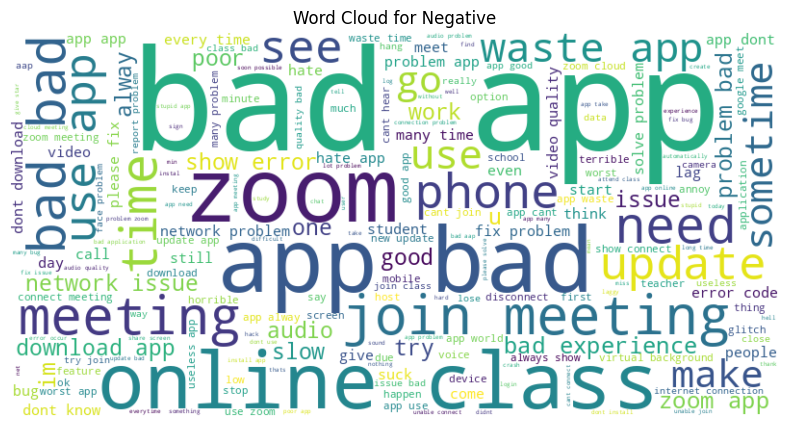

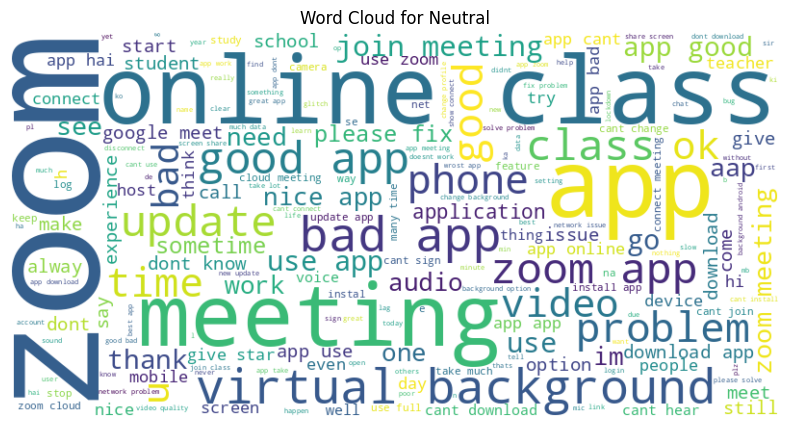

In [19]:
labels = ['positive', 'negative', 'neutral']
for label in labels:
    text = ' '.join(df_clean[df_clean['sentimen_lexicon'] == label]['Review_Final'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label.capitalize()}')
    plt.show()

### Explorasi Kata yang Sering Muncul

In [20]:
all_words = ' '.join(df_clean['Review_Final']).split()
print(Counter(all_words).most_common(20))

[('app', 194433), ('good', 83390), ('zoom', 57630), ('meeting', 57093), ('use', 40304), ('class', 39757), ('bad', 36596), ('nice', 32700), ('problem', 28366), ('online', 27891), ('work', 26775), ('time', 26025), ('please', 24731), ('video', 23483), ('cant', 22271), ('like', 21623), ('best', 20573), ('update', 18981), ('get', 17720), ('great', 16613)]


### Melakukan Downsampling

Aagar model tidak bias terhadap kelas mayoritas dan mampu mengenali sentimen dari semua kelas secara adil, maka dilakukan downsampling. Dengan menyeimbangkan distribusi data, performa model dalam mengklasifikasikan sentimen minoritas dapat meningkat dan hasil analisis menjadi lebih akurat.

In [21]:
min_class_count = df_clean['sentimen_lexicon'].value_counts().min()

df_downsampled = df_clean.groupby('sentimen_lexicon').apply(
    lambda x: x.sample(n=min_class_count, random_state=42)
).reset_index(drop=True)

print(df_downsampled['sentimen_lexicon'].value_counts())
df_clean = df_downsampled

<ipython-input-21-c937ccbf1e66>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_downsampled = df_clean.groupby('sentimen_lexicon').apply(


sentimen_lexicon
negative    80055
neutral     80055
positive    80055
Name: count, dtype: int64


In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240165 entries, 0 to 240164
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Review                   240165 non-null  object
 1   Review_Tokenized         240165 non-null  object
 2   Review_Final             240165 non-null  object
 3   Rating                   240165 non-null  int64 
 4   sentimen_score_lexicon   240165 non-null  int64 
 5   sentimen_lexicon         240165 non-null  object
 6   sentimen_rating          240165 non-null  object
 7   sentimen_score_combined  240165 non-null  int64 
 8   sentimen_combined        240165 non-null  object
dtypes: int64(3), object(6)
memory usage: 16.5+ MB


In [23]:
df_clean.to_csv('data_label.csv', index=False)